### Analytics Vidhya Jobathon - Feb 2022 - Swapna Samir Shukla ###

#### Approach ####
<br> The problem was formulated as a Simple Regression Model with H20 AutoML. I chose H20 AutoML as it takes away the manual effort involved in Hyperparameter Tuning, and is faster, so that we can spend more time on understanding the Data </br>

<br> Steps Involved : </br>
1) Data Preporocessing : Tried various transformations on Views and Followers, such as Log Transform, Sqrt Transform but there wasn't much improvement in R2 score

Age Binning : Binning was done to group age into equal sized Quantiles. Performed Better than Manual Binning. This is because manual binning introduces skewness in the data, and the feature loses its relative importance

2) Feature Engineering : Created a Feature called Views/Followers which is a simple representation for number of views per followers

3) Outlier Detection and Removal : Used Box Plots to detect and remove Outliers. Data with Engagement Score of < 1.025 were removed

4) Modelling : Ran H2o AutoMl which did a 5 fold CV, and chose a stacked GBM as the final model. The CV scores were consistent

#### What did not Work ####

1) User-User Collaborative Filtering gave a Public LB R2 score of less than 0.4 (around 0.38) and was therefore ignored at the expence of Tree Based Regression Algorithm

#### Future Scope ####
ALS ( Alternating Least Squares) Algorithm works on distributed systems. ALS is implemented in Apache Spark ML and is usually used to solve large scale collaborative filtering problems
For reference refer to my past work where I built a Recommendation System using ALS : https://github.com/swapnasamirshukla/ALS-Recommendation

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train_0OECtn8.csv")
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


In [3]:
# Quantile Binning of Age Column to make uniformly distributed bins
train['bins'] = pd.qcut(train['age'], q=4, precision=1, labels=['teens','early20','late20','others'])

(array([23739., 26488., 19196., 19774.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

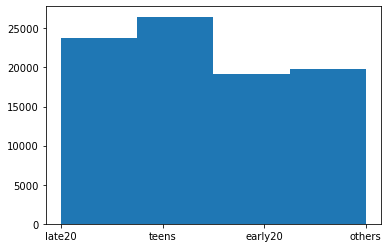

In [4]:
# Visualise Results
plt.hist(train['bins'],bins=4)

In [51]:
# Get the bin ranges
cats,bins = pd.qcut(train['age'], q=4,retbins=True)

In [56]:
cats

0         (23.0, 32.0]
1        (9.999, 18.0]
2         (18.0, 23.0]
3         (18.0, 23.0]
4         (23.0, 32.0]
             ...      
89192     (23.0, 32.0]
89193     (23.0, 32.0]
89194     (23.0, 32.0]
89195     (32.0, 68.0]
89196    (9.999, 18.0]
Name: age, Length: 89197, dtype: category
Categories (4, interval[float64, right]): [(9.999, 18.0] < (18.0, 23.0] < (23.0, 32.0] < (32.0, 68.0]]

In [55]:
bins

array([10., 18., 23., 32., 68.])

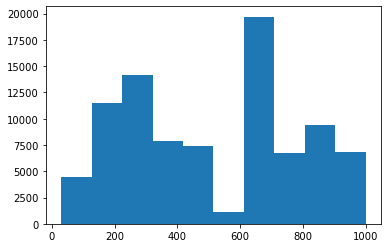

In [5]:
plt.hist(train['views'])
plt.show()

In [6]:
train['log_followers'] = np.log(train['followers'])

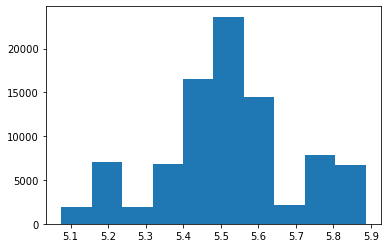

In [8]:
plt.hist(train['log_followers'])
plt.show()
# This gives a roughly normal distribution for Followers

In [11]:
# Create a new feature : views_per_followers
train['views_per_followers'] = train['views']/train['followers']

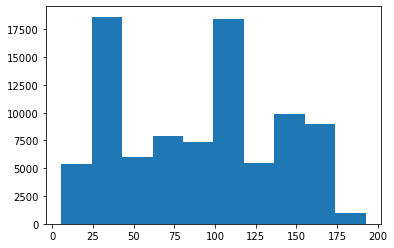

In [12]:
plt.hist(train['views']/train['log_followers'])
plt.show()

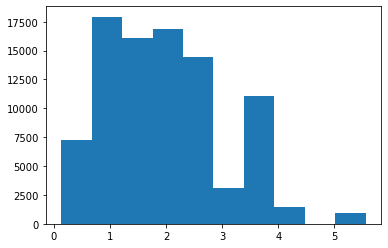

In [13]:
plt.hist(train['views']/train['followers'])
plt.show()

In [14]:
df_train = train.copy()

In [15]:
df_train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,bins,log_followers,views_per_followers
0,1,19990,37,128,24,Male,Student,180,1000,4.33,late20,5.192957,5.555556
1,2,5304,32,132,14,Female,Student,330,714,1.79,teens,5.799093,2.163636
2,3,1840,12,24,19,Male,Student,180,138,4.35,early20,5.192957,0.766667
3,4,12597,23,112,19,Male,Student,220,613,3.77,early20,5.393628,2.786364
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13,late20,5.393628,2.786364


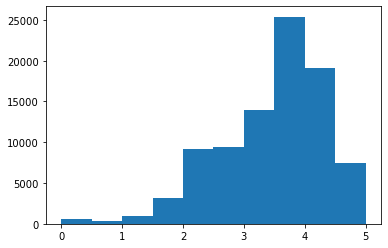

In [16]:
plt.hist(train['engagement_score'])
plt.show()

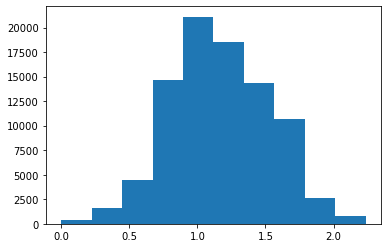

In [17]:
# Target Transformation makes it roughly normal, but is of no use for unseen data
plt.hist((np.sqrt(max(train['engagement_score'])-train['engagement_score'])))
plt.show()

In [18]:
# This doesn't appear in the final model
df_train['score_transformed'] = np.sqrt(train['engagement_score'])

<AxesSubplot:xlabel='engagement_score'>

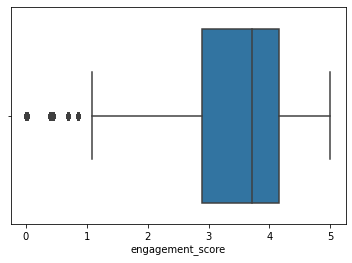

In [19]:
sns.boxplot(df_train['engagement_score']) # Outlier Detection

<AxesSubplot:xlabel='score_transformed'>

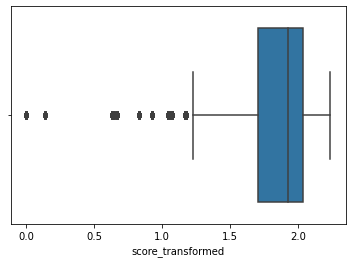

In [20]:
sns.boxplot(df_train['score_transformed'])

In [21]:
# Use Interquartile method for outlier Removal
Q1 = np.percentile(df_train['engagement_score'], 25,
                   interpolation = 'midpoint')

Q3 = np.percentile(df_train['engagement_score'], 75,
                   interpolation = 'midpoint')
IQR = Q3-Q1

In [22]:
# Above Upper bound
upper = (Q3+1.5*IQR)
 
print("Upper bound:",upper)
#print(np.where(upper))
 
# Below Lower bound
lower = (Q1-1.5*IQR)
print("Lower bound:", lower)
#print(np.where(lower))

Upper bound: 6.025
Lower bound: 1.0250000000000004


In [24]:
df_train[df_train['engagement_score']<lower] # See the data with engagement scores below Lower Bound

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,bins,log_followers,views_per_followers,score_transformed
12,13,7626,5,72,36,Female,Working Professional,240,229,0.00,others,5.480639,0.954167,0.000000
136,137,26246,30,83,26,Female,Other,230,862,0.02,late20,5.438079,3.747826,0.141421
148,149,20200,32,133,13,Female,Student,330,714,0.40,teens,5.799093,2.163636,0.632456
177,178,26505,12,30,25,Female,Other,180,138,0.69,late20,5.192957,0.766667,0.830662
204,205,20336,11,41,36,Female,Other,250,180,0.69,others,5.521461,0.720000,0.830662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88618,88619,18214,19,46,18,Female,Student,230,369,0.40,teens,5.438079,1.604348,0.632456
88997,88998,5436,12,24,32,Female,Other,180,138,0.69,late20,5.192957,0.766667,0.830662
89057,89058,8242,11,40,27,Female,Other,250,180,0.00,late20,5.521461,0.720000,0.000000
89087,89088,5951,34,95,32,Female,Other,230,840,0.69,late20,5.438079,3.652174,0.830662


In [26]:
# Lower bound
lower = np.where(df_train['engagement_score'] <= (Q1-1.5*IQR))
 
#Remove Outliers
df_train.drop(lower[0], inplace = True)
 
print("New Shape: ", df_train.shape)

New Shape:  (88377, 14)


In [27]:
train.shape

(89197, 13)

In [28]:
df_train.columns

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score', 'bins',
       'log_followers', 'views_per_followers', 'score_transformed'],
      dtype='object')

In [29]:
numericCols = ['followers', 'views', 'engagement_score','log_followers', 'views_per_followers']

<AxesSubplot:>

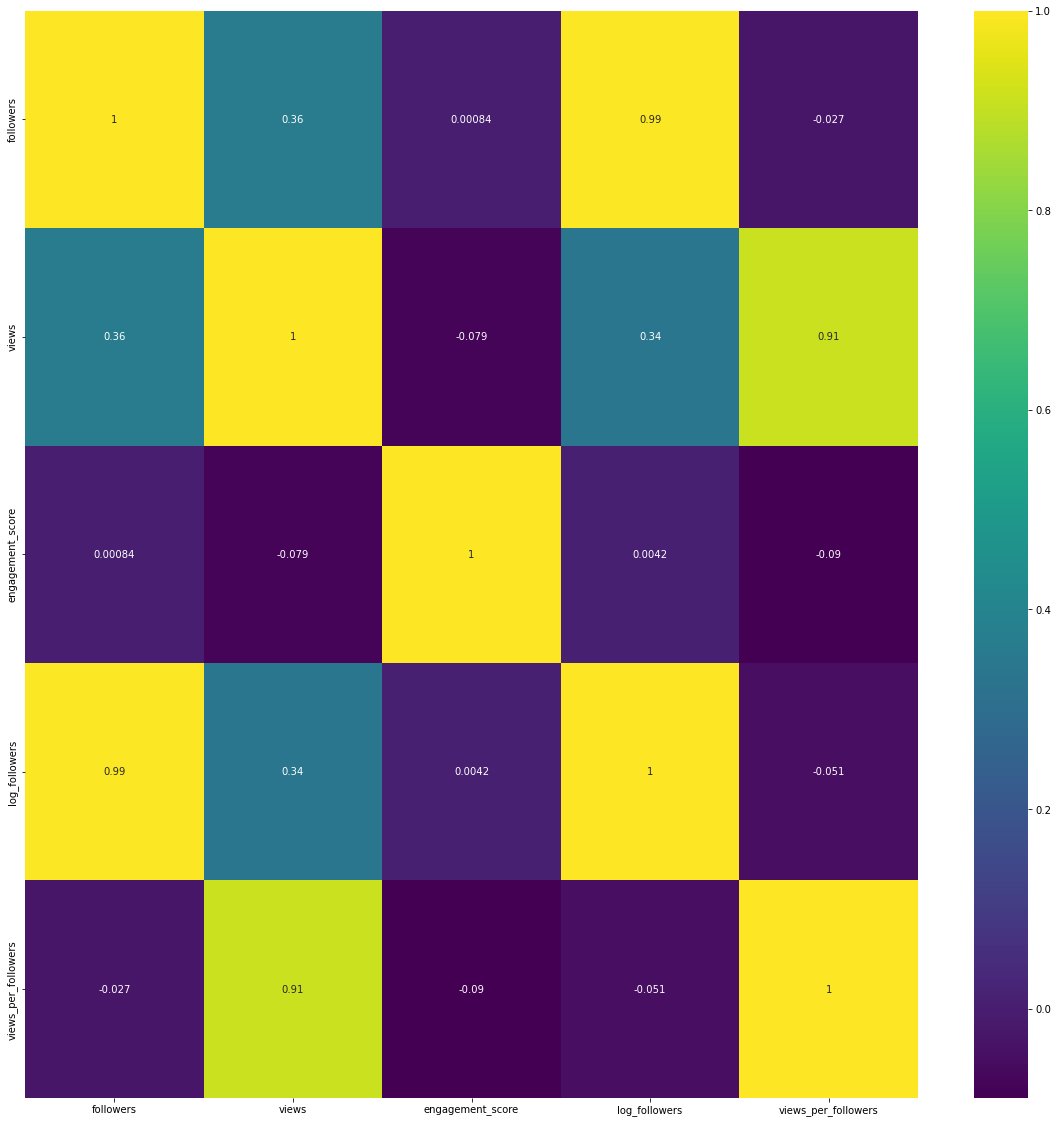

In [30]:
plt.figure(figsize=(20, 20))

sns.heatmap(df_train[numericCols].corr(), annot=True, cmap='viridis')

In [31]:
# Prepare Data for Modelling
train_model = df_train.drop(['followers', 'views','score_transformed','age','row_id','log_followers'],axis=1) 

In [32]:
# test transform
test = pd.read_csv("test_1zqHu22.csv")
def age_bin(row):
    if row<=18:
        return 'teens'
    elif row>18 and row<=23:
        return 'early20'
    elif row>23 and row<=32:
        return 'late20'
    else:
        return 'others'
test['bins'] = test['age'].apply(age_bin)

In [33]:
test['views_per_followers'] = test['views']/test['followers']

In [34]:
df_test = test.copy()

In [35]:
# Prepare data for Evaluation
test_model = df_test.drop(['followers', 'views','age','row_id'],axis=1)

In [36]:
# Initiate h2o server
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\shuklas\AppData\Local\Temp\tmptygf5gmx
  JVM stdout: C:\Users\shuklas\AppData\Local\Temp\tmptygf5gmx\h2o_shuklas_started_from_python.out
  JVM stderr: C:\Users\shuklas\AppData\Local\Temp\tmptygf5gmx\h2o_shuklas_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_shuklas_4mdzz0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.408 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [37]:
# Convert Pandas Dataframe to H2o Frames
train_model = h2o.H2OFrame(train_model)
test_model = h2o.H2OFrame(test_model)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [38]:
# Label Encode train Categorical Columns
train_model['user_id'] = train_model['user_id'].asfactor()
train_model['video_id'] = train_model['video_id'].asfactor()
train_model['category_id'] = train_model['category_id'].asfactor()

In [39]:
# Label Encode test Categorical Columns
test_model['user_id'] = test_model['user_id'].asfactor()
test_model['video_id'] = test_model['video_id'].asfactor()
test_model['category_id'] = test_model['category_id'].asfactor()

In [40]:
# Segregate X and y Columns
x = train_model.columns
y = 'engagement_score'
x.remove('engagement_score')

In [41]:
# Train Model
aml = H2OAutoML(seed=1) 
# Run AutoML for YY base models (limited to 1 hour max runtime by default)
#aml = H2OAutoML(max_models=10, seed=1234, exclude_algos = ["StackedEnsemble"],
                #sort_metric = 'rmse' 
                #balance_classes = True, 
                #sort_metric = 'logloss'
               #)
aml.train(x=x, y=y, training_frame=train_model)

AutoML progress: |
13:27:32.84: AutoML: XGBoost is not available; skipping it.
13:27:32.117: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:27:32.117: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20220214_132731

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14447887817285482
RMSE: 0.38010377290005265
MAE: 0.28017464663224223
RMSLE: 0.09654641823857157
R^2: 0.7781303052291495
Mean Residual Deviance: 0.14447887817285482
Null degrees of freedom: 9929
Residual degrees of freedom: 9923
Null deviance: 6467.625557870014
Residual deviance: 1434.6752602564484
AIC: 8985.323266940311

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE:

In [42]:
model = aml.leader 
preds_1 = model.predict(test_model)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [43]:
submission = pd.DataFrame()
submission['row_id'] = test['row_id']
submission['engagement_score'] = h2o.as_list(preds_1)['predict']

In [44]:
submission.to_csv('submit-avjb2022.csv',index=False)